In [108]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt


import xgboost 

In [109]:
# Load data
folder = "2012-and-2016-presidential-elections/"

county_fact_dict = pd.read_csv(folder+"county_facts_dictionary12_16.csv")
county_facts = pd.read_csv(folder+"county_facts12_16.csv")
county_results = pd.read_csv(folder+"US_County_Level_Presidential_Results_12-16.csv")
votes = pd.read_csv(folder+"votes12_16.csv")

In [110]:
county_fact_dict.dtypes

column_name    object
description    object
dtype: object

In [111]:
# Create target variable

def target_function(row):
    if (row['per_dem_2012'] - row['per_dem_2016']) >= (0.4*row['per_dem_2012']):
        return 1
    else:
        return 0
    
county_results['target'] = county_results.apply(target_function, axis=1)
print(sum(county_results['target']))
print(len(county_results))
print(sum(county_results['target'])/len(county_results))

144
3141
0.045845272206303724


In [112]:
# Join tables

data = pd.merge(county_results, county_facts, how="inner", left_on="FIPS", right_on="fips" )

In [113]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [114]:
data.columns

Index(['combined_fips', 'votes_dem_2016', 'votes_gop_2016', 'total_votes_2016',
       'per_dem_2016', 'per_gop_2016', 'diff_2016', 'per_point_diff_2016',
       'state_abbr', 'county_name', 'FIPS', 'total_votes_2012',
       'votes_dem_2012', 'votes_gop_2012', 'county_fips', 'state_fips',
       'per_dem_2012', 'per_gop_2012', 'diff_2012', 'per_point_diff_2012',
       'target', 'fips', 'area_name', 'state_abbreviation', 'PST045214',
       'PST040210', 'PST120214', 'POP010210', 'AGE135214', 'AGE295214',
       'AGE775214', 'SEX255214', 'RHI125214', 'RHI225214', 'RHI325214',
       'RHI425214', 'RHI525214', 'RHI625214', 'RHI725214', 'RHI825214',
       'POP715213', 'POP645213', 'POP815213', 'EDU635213', 'EDU685213',
       'VET605213', 'LFE305213', 'HSG010214', 'HSG445213', 'HSG096213',
       'HSG495213', 'HSD410213', 'HSD310213', 'INC910213', 'INC110213',
       'PVY020213', 'BZA010213', 'BZA110213', 'BZA115213', 'NES010213',
       'SBO001207', 'SBO315207', 'SBO115207', 'SBO215207'

In [115]:
modelling_col = ['per_dem_2012','PST045214',
       'PST040210', 'PST120214', 'POP010210', 'AGE135214', 'AGE295214',
       'AGE775214', 'SEX255214', 'RHI125214', 'RHI225214', 'RHI325214',
       'RHI425214', 'RHI525214', 'RHI625214', 'RHI725214', 'RHI825214',
       'POP715213', 'POP645213', 'POP815213', 'EDU635213', 'EDU685213',
       'VET605213', 'LFE305213', 'HSG010214', 'HSG445213', 'HSG096213',
       'HSG495213', 'HSD410213', 'HSD310213', 'INC910213', 'INC110213',
       'PVY020213', 'BZA010213', 'BZA110213', 'BZA115213', 'NES010213',
       'SBO001207', 'SBO315207', 'SBO115207', 'SBO215207', 'SBO515207',
       'SBO415207', 'SBO015207', 'MAN450207', 'WTN220207', 'RTN130207',
       'RTN131207', 'AFN120207', 'BPS030214', 'LND110210', 'POP060210']

In [116]:
# Save modelling data in csv with fips

data.to_csv('total_data.csv')

In [117]:
# Build prediction model

X_train, X_test, y_train, y_test = train_test_split(data[modelling_col], 
                                                    data['target'], 
                                                    test_size=0.33, 
                                                    random_state=42)


In [118]:
# Create model

model = xgboost.XGBRegressor()

In [119]:
model.fit(X_train, y_train)

C:\Users\Viktor\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[21:25:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

129
0.7253044035521374


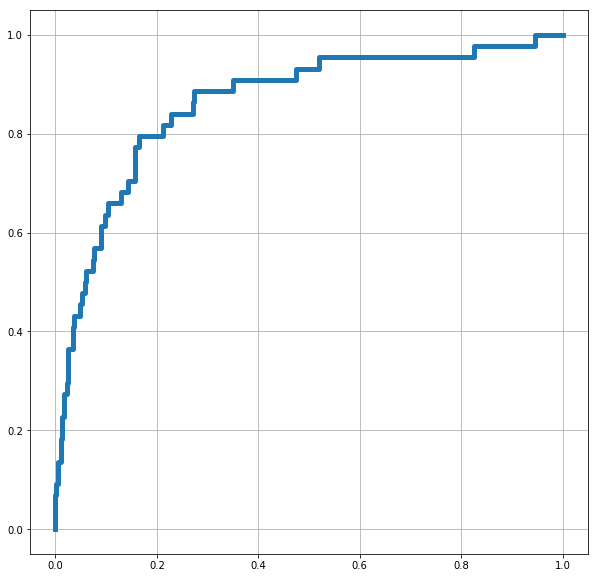

In [120]:
plt.figure(figsize=(10,10))

def plot_gini(y_predict, y_actual):
    
    fpr, tpr, thresh = roc_curve(y_actual, y_predict)
    
    
    #for i in [0.2, 0.4, 0.6, 0.8]:
    #    x_plot.append(1/100)
    print(len(fpr))
    plt.plot(fpr, tpr, linewidth=5)
    plt.grid()
    
plot_gini(model.predict(X_test), y_test)
auc = roc_auc_score(y_test,model.predict(X_test))

print(2*auc-1)    

In [121]:
import shap
import os


# Import names
names = pd.read_csv("2012-and-2016-presidential-elections/county_facts_dictionary12_16.csv")

name_match = {}
for k,v in zip(list(names['column_name']), list(names['description'])):
    name_match[k] = v
feature_names = [name_match[i] if i in name_match.keys() else i for i in model.get_booster().feature_names]

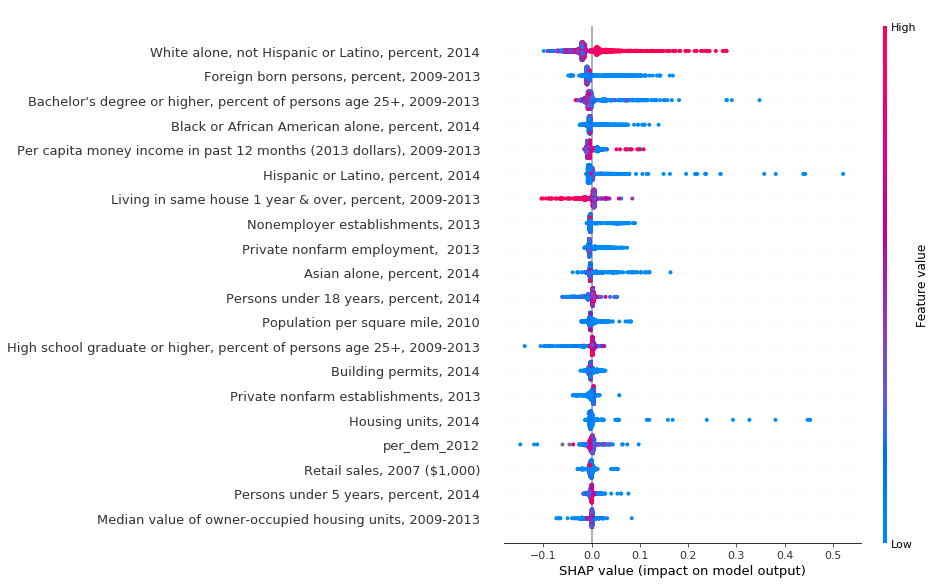

In [122]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, feature_names=feature_names)

In [123]:
import joblib

joblib.dump(model, "predict_model.joblib")

['predict_model.joblib']

## Pytorch NN model


In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F

len(modelling_col)

52

In [125]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(52, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
my_net = Net()
print(my_net)

Net(
  (fc1): Linear(in_features=52, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [126]:
params = list(my_net.parameters())
print(len(params))
print(params[0].size())

6
torch.Size([120, 52])


In [127]:
input = torch.randn(1,52)
out = my_net(input)
print(out)

tensor([[0.0162, 0.0531]], grad_fn=<AddmmBackward>)


In [128]:
my_net.zero_grad()
out.backward(torch.randn(1, 2))

In [129]:
output = my_net(input)
target = torch.randn(2)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.0641, grad_fn=<MseLossBackward>)


In [130]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])

In [131]:
my_net.zero_grad()     # zeroes the gradient buffers of all parameters

print('fc1.bias.grad before backward')
print(my_net.fc1.bias.grad)
loss.backward()
print('fc1.bias.grad after backward')
print(my_net.fc1.bias.grad)


fc1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
fc1.bias.grad after backward
tensor([ 8.2186e-03,  9.6968e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         3.1411e-03,  0.0000e+00,  7.8625e-03,  1.0104e-02, -2.7438e-03,
         0.0000e+00, -1.4609e-03, -1.0767e-03,  0.0000e+00, -5.0248e-03,
         2.7880e-03,  0.0000e+00,  0.0000e+00, -1.4890e-03,  0.0000e+00,
         1.4084e-03,  2.0063e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  7.6156e-03, -6.0444e-03,  0.0000e

In [133]:
learning_rate = 0.01
for f in my_net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [135]:
for f in my_net.parameters():
    print(f)

Parameter containing:
tensor([[-0.0436,  0.1306, -0.0606,  ..., -0.1277,  0.0526, -0.0275],
        [-0.0826,  0.0249,  0.1097,  ...,  0.0819, -0.1205,  0.0013],
        [-0.1252, -0.0764,  0.0901,  ...,  0.0994, -0.0013,  0.1345],
        ...,
        [ 0.1233,  0.0190, -0.1082,  ...,  0.0671,  0.0471,  0.0152],
        [-0.0713, -0.0606,  0.1282,  ..., -0.0161, -0.0926, -0.0254],
        [-0.0369, -0.0551, -0.0244,  ...,  0.0223,  0.0905, -0.1308]],
       requires_grad=True)
Parameter containing:
tensor([-0.1154,  0.0756, -0.1064,  0.0629, -0.0292,  0.0334, -0.1170,  0.0648,
        -0.0317,  0.0878, -0.0930,  0.0317, -0.0181, -0.0931,  0.0413, -0.1119,
         0.0154,  0.1220,  0.0529, -0.1182,  0.0760, -0.0075, -0.0510,  0.1164,
        -0.0476, -0.0513,  0.1310, -0.0765, -0.1301, -0.0505,  0.0633, -0.0543,
         0.0766,  0.0803, -0.0983, -0.0807, -0.0086,  0.1334, -0.1203, -0.0585,
         0.0910, -0.0415, -0.0838, -0.1310,  0.0536,  0.0368, -0.0295, -0.0237,
         0.0813